# House Prices: Advanced Regression Techniques

Dane użyte w tym notatniku dotyczą nieruchomości i pochodzą z konkursu udostępnionego na Kaggle. Zacznę od wczytania podstawowych bibliotek oraz treningowej bazy danych.

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mpls
mpls.use('ggplot')
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [249]:
data_train = pd.read_csv('data/train.csv',index_col='Id')

In [250]:
data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Regresja liniowa

W pierwszej części powtórzę to co zostało przedstawione w zeszycie https://github.com/Kolo-Naukowe-Data-Science-PW/Spotkania/blob/master/18-10-25_regresja_domy/linear_regression.ipynb, aby potem uzupełnić to o inne metody na obliczenie regresji liniowej i porównać je. Poniższa funkcja ma za zadanie przygotowanie danych do obliczeń:

- miesza kolejność rzędów
- tworzy wektor zmiennych niezależnych z kolumn o podanych nazwach
- tworzy wektor zmiennych zależnych z kolumn o podanych nazwach
- dzieli oba wektory na zbiory treningowy i testowy według podanej proporcji

In [251]:
def data_processing(data,X_names,Y_names,cv=0.8,seed=123):
    data = data.sample(data.shape[0],random_state=seed)
    dataX = data.loc[:,X_names].values
    dataX = np.c_[np.ones(dataX.shape[0]),dataX]
    dataY = data.loc[:,Y_names].values
    trainX = dataX[:int(data.shape[0]*cv),:]
    cvX = dataX[int(data.shape[0]*cv):,:]
    trainY = dataY[:int(data.shape[0]*cv)]
    cvY = dataY[int(data.shape[0]*cv):]
    return trainX,cvX,trainY,cvY

Użyję utworzonej funkcji do uzyskania informacji z kolumny 'LotArea' jako zmiennej niezależnej i 'SalePrice' jako zmiennej zależnej.

In [252]:
trainX,cvX,trainY,cvY = data_processing(data_train,'LotArea','SalePrice')

Poniżej zostaną wyliczone parametry regresji liniowej za pomocą metody namniejszych kwadratów, a następnie zależność zostanie przedtawiona na wykresie.

In [253]:
def OLS_model(data_x,data_y):
    return (np.linalg.inv(data_x.transpose() @ data_x) @ data_x.transpose() @ data_y).reshape(2,1)

In [254]:
betaOLS = OLS_model(trainX,trainY)

In [255]:
def plotting(train_x,train_y,test_x,test_y,beta):
    fig = plt.figure(figsize=(12,8))
    ax = fig.subplots()
    ax.set_title('Predykcja ceny domu na podstawie wielkosci działki',size=20)
    ax.scatter(train_x[:,1],train_y,label='train set')
    ax.scatter(test_x[:,1],test_y,label='test set')
    ax.plot(np.r_[train_x,test_x][:,1],np.r_[train_x,test_x] @ beta,
            linestyle='-',color='green',linewidth=3,label='regresja')
    ax.legend()
    ax.set_xlabel('wielkosc dzialki $(feet^2)$',size=15)
    ax.set_ylabel('cena dzialki',size=15)

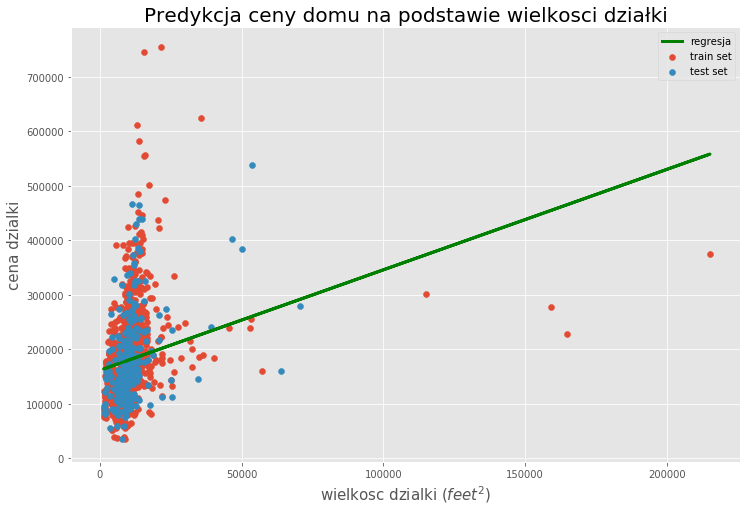

In [256]:
plotting(trainX,trainY,cvX,cvY,betaOLS)

Kilka z obserwacji charakteryzuje się bardzo dużą powierzchnią działki, ale niską ceną. Ponieważ nie wnoszą one dużo do zrozumienia zależności zostaną one usunięte ze zbioru, a następnie spróbuję dopasować nową prostą.

In [257]:
trainX,trainY = trainX[trainX[:,1]<45000,:],trainY[trainX[:,1]<45000]

In [258]:
betaOLS_wo = OLS_model(trainX,trainY)

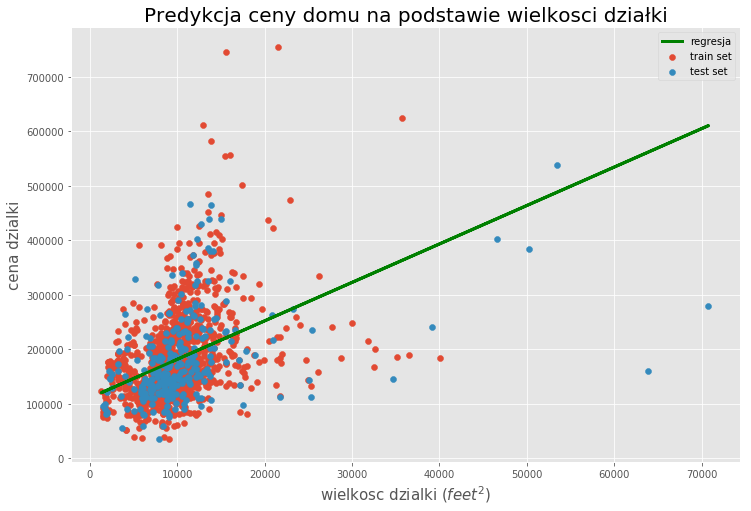

In [259]:
plotting(trainX,trainY,cvX,cvY,betaOLS_wo)

Wykres pokazuje że dla większych działek regresja nie działa zbyt dobrze. Spróbuję się tym zająć w późniejszej części.

# Inne sposoby na metodę najmniejszych kwadratów

Obliczenia parametrów regrsji można przeprowadzić na kilka różnych sposobów. Tzw macierz pseudoodwrotna może też zostać obliczona z macierzy uzyskanych z SVD lub dekompozycji QR. Wykorzystam również gotowy algorytm z biblioteki sklearn.

In [260]:
def SVD_model(data_x,data_y):
    U, S, V = np.linalg.svd(data_x,full_matrices=False)
    return (((V.T @ np.diag(1/S)) @ U.T) @ data_y).reshape(2,1)

In [261]:
betaSVD = SVD_model(trainX,trainY)

In [262]:
def QR_model(data_x,data_y):
    Q, R = np.linalg.qr(data_x)
    return ((np.linalg.inv(R) @ Q.T) @ data_y).reshape(2,1)

In [263]:
betaQR = QR_model(trainX,trainY)

In [264]:
regressor = LinearRegression()
regressor.fit(trainX,trainY)
betaSKL = np.array([[regressor.intercept_],[regressor.coef_[1,]]])

Porównanie parametrów wyliczonych na 4 sposoby

In [265]:
print('Normalnie: stała:\t',betaOLS_wo[0,0], '\twspółczynnik:',betaOLS_wo[1,0])
print('SVD: stała:\t\t',betaSVD[0,0], '\twspółczynnik:',betaSVD[1,0])
print('QR: stała:\t\t',betaQR[0,0], '\twspółczynnik:',betaQR[1,0])
print('sklearn: stała:\t\t',betaSKL[0,0], '\twspółczynnik:',betaSKL[1,0])

Normalnie: stała:	 111311.58078390834 	współczynnik: 7.055605055730098
SVD: stała:		 111311.5807839082 	współczynnik: 7.0556050557300924
QR: stała:		 111311.58078390823 	współczynnik: 7.055605055730094
sklearn: stała:		 111311.58078390833 	współczynnik: 7.055605055730093


Obliczone parametry są właściwie identyczne.

# Transformacja logarytmiczna

Jak było widać wcześniej, regresja przybliżała gorzej ceny działek o dużej powierzchni. Sprawdźmy czy to prawda za pomocą wykresu.

In [266]:
import matplotlib.gridspec as gridspec
def residual(train_x,train_y,test_x,test_y,beta):
    fig = plt.figure(figsize=(12,8))
    grid = gridspec.GridSpec(ncols=3,nrows=1,figure=fig)
    ax = fig.add_subplot(grid[0,:2])
    ax2 = fig.add_subplot(grid[0:,2])
    ax.set_title('Residual plot',size=20)
    ax.scatter(trainX[:,1],train_y - (train_x @ beta).squeeze(),label='train set')
    ax.scatter(cvX[:,1],test_y - (test_x @ beta).squeeze(),label='test set')
    ax.legend()
    ax.set_xlabel('wielkosc dzialki $(feet^2)$',size=15)
    ax.set_ylabel('błąd',size=15)
    ax2.hist(train_y - (train_x @ beta).squeeze(),orientation='horizontal',bins=10)
    ax2.hist(test_y - (test_x @ beta).squeeze(),orientation='horizontal',bins=10)
    ax2.tick_params(axis='y',which='both',left=False,labelleft=False)

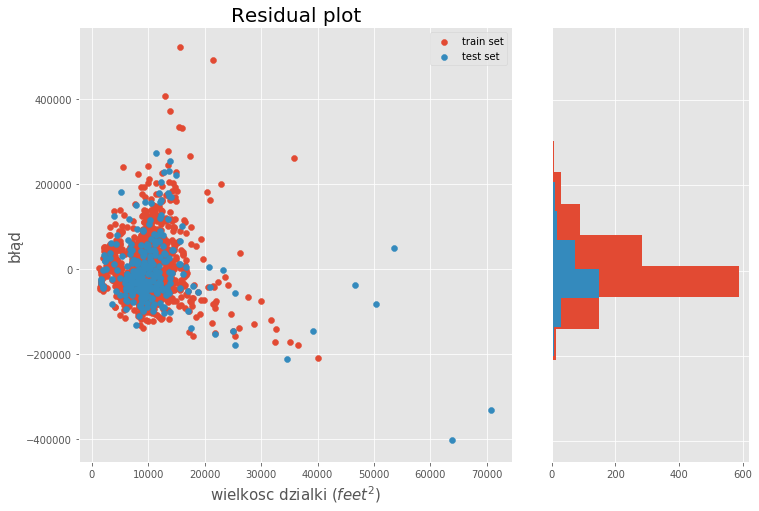

In [267]:
residual(trainX,trainY,cvX,cvY,betaOLS_wo)

Aby zredukować problem z zależnością błędu od zmiennych użyję transformacji logarytmicznej na obu zmiennych.

In [268]:
beta_log = OLS_model(np.log1p(trainX),np.log1p(trainY))

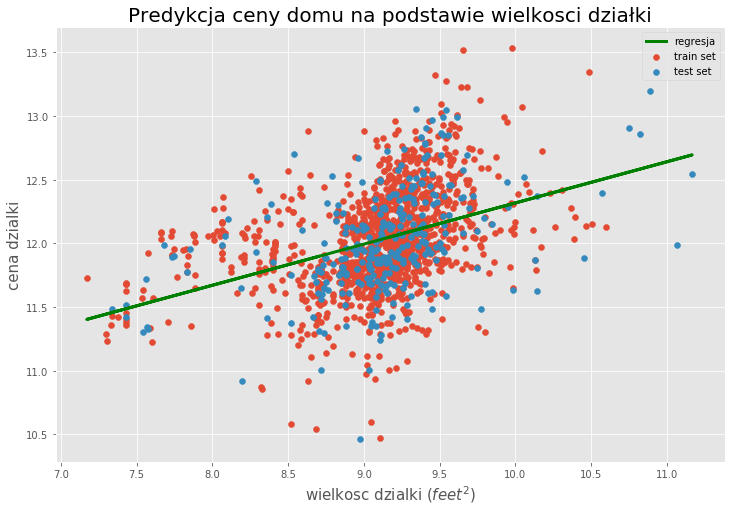

In [269]:
plotting(np.log1p(trainX),np.log1p(trainY),np.log1p(cvX),np.log1p(cvY),beta_log)

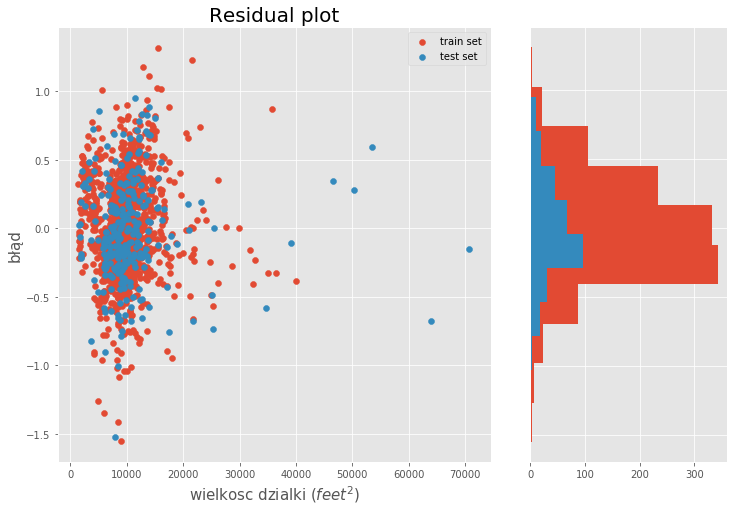

In [270]:
residual(np.log1p(trainX),np.log1p(trainY),np.log1p(cvX),np.log1p(cvY),beta_log)

Użycie transformacji logarytmicznej poprawiło wyniki modelu.

In [271]:
from sklearn.metrics import r2_score
print('R2 bez transformatcji: \t',r2_score(cvY,cvX @ betaOLS_wo))
print('R2 po transformacji: \t',r2_score(np.log1p(cvY),np.log1p(cvX) @ beta_log))

R2 bez transformatcji: 	 0.05960085705792584
R2 po transformacji: 	 0.18426526974870505


# Predykcja z użyciem wszystkich kolumn

W następnych rozdziałach spróbuję przeprowadzić predykcję za pomocą algorytmów dwóch algorytmów znaelzionych na stronie konkursu:

- model stacking z https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
- xgboost z https://www.kaggle.com/humananalog/xgboost-lasso/code

# Data preparation

Dataset musi zostać najpierw odpowiednio przygotowany, aby mógł zostać wykorzystany do trenowania modelów.

In [320]:
data = data_train.copy()

W datasecie kilka pozycji otrzymało status Nan przy wczytaniu datasetu. W większości wypadków jest to po prostu brak jakiejś cechy nieruchomości jak garaż czy płot. W kilku przypadkach danej rzeczywiście brakuje i zostaną one zastąpione jakąś założoną wartośćią.

In [321]:
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean())) 
                                                                         #brakujące dane o długości boku przylegającego do 
                                                                         #ulicy zostały uzupełnione za pomocą średniej
                                                                         #dla dzielnicy
data['Alley'] = data['Alley'].fillna('None')
data['MiscFeature'] = data['MiscFeature'].fillna('None')
data['Fence'] = data['Fence'].fillna('None')
data['PoolQC'] = data['PoolQC'].fillna('None')
data['GarageType'] = data['GarageType'].fillna('None')
data['GarageYrBlt'] = data['GarageYrBlt'].fillna('None')
data['GarageFinish'] = data['GarageFinish'].fillna('None')
data['GarageQual'] = data['GarageQual'].fillna('None')
data['GarageCond'] = data['GarageCond'].fillna('None')
data['FireplaceQu'] = data['FireplaceQu'].fillna('None')
data['BsmtQual'] = data['BsmtQual'].fillna('None')
data['BsmtFinType1'] = data['BsmtFinType1'].fillna('None')
data['BsmtCond'] = data['BsmtQual'].fillna('None')
data.loc[data['BsmtExposure'].isnull(),['BsmtFinType1','BsmtFinType2','BsmtExposure']] = 'None' 
                                                                        #jedna pozycja miala piwnice oznaczone jako
                                                                        #nieskonczone, ale brak piwnicy w innej kolumnie
                                                                        #i powierzchnie równe zero, wpisano brak wszędzie 
            
data['BsmtFinType2'] = data['BsmtFinType2'].fillna('Unf') #brak danej na temat powierzchni drugiej piwnicy, ale jest 
                                                          #informacja o jej powierzchni, wpisano najczęstszą kategorię
    
data['Electrical'] = data['Electrical'].fillna('SBrkr') #brak danych uzupełniono najczestszą kategorią
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

W kolejnym kroku należy zastąpić zmienne kategoryczne na liczbowe. Najpierw zamienię niektóre zmienne kategoryczne, które mogę uznać za uporządkowane.

In [322]:
mapp = {'Ex':0,    #każdej opisowej wartości zostaje przypisana wartość liczbowa, sekwencja liczb jest uporzadkowana
        'Gd':1,   
        'TA':2,
        'Fa':3,
        'Po':4,
        'None':5}
data[['ExterQual','ExterCond','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond','FireplaceQu']] = data[['ExterQual','ExterCond','BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond','FireplaceQu']].replace(mapp)
mapp = {'Gd':0,
        'TA':1,
        'Fa':2,
        'Po':3,
        'None':4}
data[['PoolQC']] = data[['PoolQC']].replace(mapp)
mapp = {'Fin':0,
        'RFn':1,
        'Unf':2,
        'None':3}
data[['GarageFinish']] = data[['GarageFinish']].replace(mapp)
mapp = {'Ex':0,
        'Gd':1,   
        'TA':2,
        'Fa':3,
        'None':4}
data[['PoolQC']] = data[['PoolQC']].replace(mapp)

Następnie użyje funkcji z biblioteki sklearn do utworzenia dummy variable dla zmiennych kategorycznych nieuporządkowanych

In [323]:
from sklearn.preprocessing import LabelEncoder

catcolumns = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood','BldgType','HouseStyle','RoofStyle','RoofMatl','MasVnrType', 'Foundation', 'Heating', 
              'BsmtQual','BsmtExposure','CentralAir', 'Electrical','Functional','GarageType','PavedDrive', 'Fence',
              'MiscFeature','SaleType', 'SaleCondition','YrSold']
for x in catcolumns:                        #na porzatku zmienne opisowe zamieniane są na liczba
    le = LabelEncoder()
    data[x] = le.fit_transform(data[x])

unorderedcat = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope',
                'Neighborhood','BldgType','HouseStyle','RoofStyle','RoofMatl','MasVnrType', 'Foundation', 'Heating',
                 'BsmtQual','BsmtExposure','CentralAir', 'Electrical','Functional','GarageType','PavedDrive', 'Fence',
                'MiscFeature','SaleType', 'SaleCondition','YrSold'] 
data = pd.get_dummies(data,columns=unorderedcat,drop_first=True,prefix=unorderedcat)
                                            #według utworzonych wczesniej liczb zostaja stworzone nowe dummy variables

Na koniec zajmę się bardziej problematycznymi zmiennymi.

In [324]:
#Kolumny Condition1 i Condition2 mogły zawierać wartości z tego samego zbioru. Dlatego utworzę wspólne dummy variables
#dla obu kolumn
le = LabelEncoder()                                                            
data['Condition1'] = le.fit_transform(data['Condition1'])
data['Condition2'] = le.transform(data['Condition2'])
cond1 = pd.get_dummies(data['Condition1'],drop_first=True,prefix='cond')        #na poczatku tworze dummy variables 
cond2 = pd.get_dummies(data['Condition2'],drop_first=True,prefix='cond')        #oddzielnie dla obu kolumn
cond =  pd.concat([cond1,cond2],sort=True).groupby(level=0).sum()               
cond = cond.astype(int)
cond[cond==2] = 1                                                               #następnie biorę część wspołną
data = pd.concat([data,cond],axis=1)                                            #dołączam nowe kolumny
data = data.drop(['Condition1','Condition2'],axis=1)                            #i usuwam zbędne kolumny


#Podobnie z kolumnami Exterior1st i Exterior2nd
le = LabelEncoder()
data.loc[data['Exterior2nd']=='Wd Shng',['Exterior2nd']] = 'Wd Sdng' #W paru rzędach popełniono literówkę
data.loc[data['Exterior2nd']=='Brk Cmn',['Exterior2nd']] = 'BrkComm'
le.fit(pd.concat([data['Exterior1st'],data['Exterior2nd']],axis=0))
data['Exterior1st'] = le.transform(data['Exterior1st'])
data['Exterior2nd'] = le.transform(data['Exterior2nd'])
ext1 = pd.get_dummies(data['Exterior1st'],drop_first=True,prefix='ext')
ext2 = pd.get_dummies(data['Exterior2nd'],drop_first=True,prefix='ext')
ext =  pd.concat([ext1,ext2],sort=True).groupby(level=0).sum()
ext = ext.astype(int)
ext[ext==2] = 1
data = pd.concat([data,ext],axis=1)
data = data.drop(['Exterior1st','Exterior2nd'],axis=1)



#Zamienię także columny 'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2' na kolumny zawierające ilość metrów
#każdego typu piwnicy w danym domu

mapp = {'GLQ':6,
        'ALQ':5,
        'BLQ':4,
        'Rec':3,                                                     #na początku tworzę dummy variables w taki sposob
        'LwQ':2,                                                     #aby nie zostal utworzony rzad odpowiadajacy
        'Unf':1,                                                     #brakowi piwnicy(wtedy powierzchnia rowna jest 0 
        'None':0}                                                    #a zalezy nam aby zachowana zostala informacja 
data['BsmtFinType1'] = data[['BsmtFinType1']].replace(mapp)          #o wszystkich innych rodzajach powierzchni
data['BsmtFinType2'] = data[['BsmtFinType2']].replace(mapp)

bs1 = pd.get_dummies(data['BsmtFinType1'],drop_first=True,prefix='bs')
bs2 = pd.get_dummies(data['BsmtFinType2'],drop_first=True,prefix='bs')

bs1['BsmtFinSF'] = data['BsmtFinSF1']                                #do tabel zawierajacych  dummy variables dolaczam
bs2['BsmtFinSF'] = data['BsmtFinSF2']                                #kolumnę z powierzchnia(odpowiedniego typu)

def fun(x):
    x[x==1] = x['BsmtFinSF']                                          #(pewnie istnieje łatwiejszy sposób)
    return x                                                          #poprzez wymnozenie w kazdym rzędzie wartosci 1
                                                                      #dummy variable z powierzchnia z ostatniej kolumny
bs = (bs1.apply(fun,axis=1) + bs2.apply(fun,axis=1))                  #uzyskuje tabele zawierajace w kazdym rzedzie
data = pd.concat([data,bs],axis=1)                                    #powierzchnie w kolumnie danego typu i 0 w reszcie
                                                                      #oczywiscie obie tabele moge dodac aby zredukowac
                                                                      #koncowa liczbe kolumn

data = data.drop(['BsmtFinSF','BsmtFinType2','BsmtFinType1','BsmtFinSF1','BsmtFinSF2'],axis=1)
                                                                       #usuwam zbędne kolumny

Pominę niektóre kolumny ze względu na to że nie wnoszą nowych/ważnych informacji (np. ilość samochodów w garażu jest związana z jego powierzchnią)

In [325]:
data = data.drop(labels=['GarageCars','TotalBsmtSF','GarageYrBlt','MoSold'],axis=1)

Usunięcie kilku outliers

In [326]:
data = data.loc[data['LotArea']<100000,:]
data = data.loc[np.logical_or(data['SalePrice']>300000,data['GrLivArea']<4000),:]

Utworzenie macierzy zmiennych niezależnych i wektora zmiennych zależnych

In [327]:
X = data.drop('SalePrice',axis=1).values
Y = data.loc[:,'SalePrice'].values

# Modelowanie

Teraz zamierzam zastosować kilka modeli do przygotowanego datasetu. Będą to: zwykła regresja liniowa, regresja Lasso, regresja z regularyzacją Tichonowa, i regresja za pomocą lasu losowego. Do porównania modeli użyję współczynnika R2 i kfold cross-validation z 5 foldami.

In [371]:
from sklearn.model_selection import KFold,cross_val_score             #przygotowanie funkcji oceniającej jakość predykcji

def scorer(regressor):
    kf = KFold(5,shuffle=True,random_state=0)
    score = np.sqrt(-cross_val_score(regressor,X,Y,scoring='neg_mean_squared_error',cv=kf))
    return score

## Testowanie różnych modeli

In [372]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
score = scorer(regressor)
print('Regresja liniowa \t\tŚrednia R2 : {:.4f} Odchylenie standardowe :{:.4f}'.format(score.mean(),score.std()))

Regresja liniowa 		Średnia R2 : 26820.9591 Odchylenie standardowe :1782.5196


In [373]:
from sklearn.linear_model import Lasso
regressor = Lasso(max_iter=100000)
score = scorer(regressor)
print('Regresja Lasso \t\t\tŚrednia R2 : {:.4f} Odchylenie standardowe :{:.4f}'.format(score.mean(),score.std()))

Regresja Lasso 			Średnia R2 : 26480.8574 Odchylenie standardowe :1873.1588


In [374]:
from sklearn.linear_model import Ridge
regressor = Ridge()
score = scorer(regressor)
print('Regresja Ridge \t\t\tŚrednia R2 : {:.4f} Odchylenie standardowe :{:.4f}'.format(score.mean(),score.std()))

Regresja Ridge 			Średnia R2 : 25385.7619 Odchylenie standardowe :2257.6614


In [375]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200)
score = scorer(regressor)
print('Las losowy \t\t\tŚrednia R2 : {:.4f} Odchylenie standardowe :{:.4f}'.format(score.mean(),score.std()))

Las losowy 			Średnia R2 : 27157.6555 Odchylenie standardowe :2255.4301


## Model stacking

Chciałbym także spróbować modelu złożonego z kilku mniejszych modeli tzw. model stacking.
Złożę go z regresji ridge i lasu losowego jako modeli podstawowych i metody lasso jako metamodelu.
Więcej informacji o model stackingu: http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [376]:
from sklearn.base import BaseEstimator


class modelstack(BaseEstimator):
    def __init__(self):                                                         
        self.rfg = RandomForestRegressor
        self.ls = Lasso
        self.rd = Ridge
        
    def fit(self,X,Y):                                                            
        kf = KFold(3,random_state=0)
        self.basemodels1 = []
        self.basemodels2 = [] 
        self.metamodel = self.rd(max_iter=100000)
        
        
        meta_features = np.zeros((X.shape[0],2))                      
        
        for i,(ixtrain,ixtest) in enumerate(kf.split(X,Y)):                 
            self.basemodels1.append(self.rfg(n_estimators=200))                             
            self.basemodels1[i].fit(X[ixtrain],Y[ixtrain])                  
            meta_features[ixtest,0] = self.basemodels1[i].predict(X[ixtest])
        
        for i,(ixtrain,ixtest) in enumerate(kf.split(X,Y)):
            self.basemodels2.append(self.ls(max_iter=100000))
            self.basemodels2[i].fit(X[ixtrain],Y[ixtrain])
            meta_features[ixtest,1] = self.basemodels2[i].predict(X[ixtest])
            
        self.metamodel.fit(meta_features,Y)                 
        
                                                            #w odniesieniu do cytowanego artykułu: przy predykcji używam 
                                                            #kilku instancji tego samego modelu podstawowego, a następnie
                                                            #jako metafeature używam średniej
    def predict(self,X):                                
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in self.basemodels1]).mean(axis=1),
                                      np.column_stack([model.predict(X) for model in self.basemodels2]).mean(axis=1)])
        return self.metamodel.predict(meta_features)

Trzymajcie kciuki!

In [377]:
regressor = modelstack()
score = scorer(regressor)
print('Regresja liniowa \t\tŚrednia R2 : {:.4f} Odchylenie standardowe :{:.4f}'.format(score.mean(),score.std()))

Regresja liniowa 		Średnia R2 : 23773.5802 Odchylenie standardowe :2325.7798


Dzięki model stackingowi udało się zmniejszyć błąd predykcji